# AutoEncoders based Image Denoising

This work is part of the experimental analysis for the paper Low Latency Video Denoising for Video Conferencing Using CNN Architectures 

Authors of this notebook, Masters Computer Science students, Seattle University Fall, 2022
 - Altanai Bisht
 - Ana Carolina Mendes
 - Justin Threson
Faculty Advisor 
- Dr Shadrokh Samavi

(MIT License)

----------------------------------------------------

* AutoEncoders for Image Denoising
  * Construct dataset from Images
  * Encode Decode model and architecture
    * Build the model
    * Model sumary
* Run and Runtime
* DeNoise Analyzer

---------------------------------------------

In [42]:
from __future__ import absolute_import, unicode_literals, print_function
from sklearn.model_selection import train_test_split

In [43]:
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import tensorflow as tf 
from keras.preprocessing import image

# for dirname, _, filenames in os.walk('/content/drive/MyDrive/RealtimeDenoising/WebRTCCapturesDataset/GT'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [44]:
# matplotlib displays color in BGR format, we are converting that to RGB
def plot_rgb_img(img):
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

def show_img(dataset):
    f, ax = plt.subplots(1,5)
    f.set_size_inches(40, 20)
    for i in range(1,3):
        ax[i-5].imshow(dataset[i].reshape(100,100), cmap='gray')
    plt.show()

## Construct dataset from Images 



*   train_df, noised_df
*   xtrain , xnoised, xtest

For training 
xtrain= train_df[5:]
xnoised= noised_df[0:5]

For validation 
xtest= noised_df[5:]




In [45]:
train_images = sorted(os.listdir('/content/drive/MyDrive/RealtimeDenoising/WebRTCCapturesDataset/train'))
imgsize=(240,320,3)
newsize=(300, 300)
train_image = []
for im in train_images:
    print(im)
    img = tf.keras.utils.load_img('/content/drive/MyDrive/RealtimeDenoising/WebRTCCapturesDataset/train/'+ im)
    img = img.resize(newsize)
    img = tf.keras.utils.img_to_array(img)
    img = img/255
    train_image.append(img)

xtrain  = np.array(train_image)
xtrain.shape

1.png
10.png
11.png
12.png
13.png
14.png
15.png
16.png
17.png
18.png
19.png
2.png
20.png
3.png
4.png
5.png
6.png
7.png
8.png
9.png


(20, 300, 300, 3)

In [46]:
def add_gaussian_blur(data):
  dst = cv2.GaussianBlur(data, (35, 35), cv2.BORDER_DEFAULT)
  return dst

# adds the gaussian noise based on the mean and the standard deviation 
def add_gaussian_noise(data):
  mean = (10, 10, 10)
  std = (50, 50, 50)
  row, col, channel = data.shape
  noise = np.random.normal(mean, std, (row, col, channel)).astype('uint8')
  return data + noise

# adds salt and pepper noise 
def add_salt_pepper_noise(data, p=0.05):
  rows, columns, channels = data.shape
  output = np.zeros(data.shape, np.uint8)
  for i in range(rows):
    for j in range(columns):
      r = np.random.random()
      if r < p/2:
        output[i][j] = [0, 0, 0]
      elif r > p/2 and r <= p:
        output[i][j] = [255, 255, 255]
      else:
        output[i][j] = data[i][j]
  return output

In [47]:
def add_gaussian_to_dataset(data):
  count = 0
  end = len(data)
  output_data = []
  while count < end:
    output_data.append(add_gaussian_noise(data[count]))
    count+=1
  return np.array(output_data)

def add_gaussian_blur_to_dataset(data):
  count = 0 
  end = len(data)
  output_data = []
  while count < end:
    output_data.append(add_gaussian_blur(data[count]))
    count+=1
  return np.array(output_data)

In [48]:
noised_df = add_gaussian_blur_to_dataset(xtrain)
noised_df.shape

(20, 300, 300, 3)

In [49]:
# # Scale the data between 0 and 1

# xtrain = xtrain / 255.0
# xtest = xtest / 255.0
# # reduce images
# xtrain_noisy = xtrain_noisy / 255.0 
# xtest_noisy = xtest_noisy / 255.0 

Groutd Truth


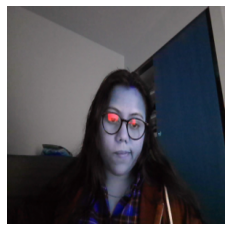

Noisy Image


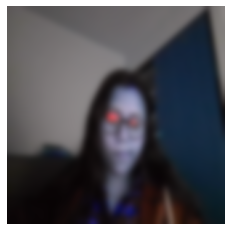

Groutd Truth


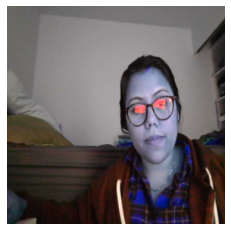

Noisy Image


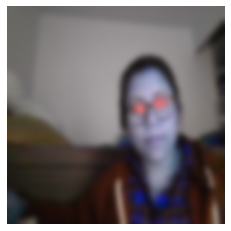

In [50]:
data = xtrain
xtrain= data[0:7]
xtrain_noisy = noised_df[0:7]

xtest= data[8:]
xtest_noisy= noised_df[8:]

# Compare the images
print("Groutd Truth")
plot_rgb_img(xtrain[3])
print("Noisy Image")
plot_rgb_img(xtrain_noisy[3])


print("Groutd Truth")
plot_rgb_img(xtest[3])
print("Noisy Image")
plot_rgb_img(xtest_noisy[3])

In [51]:
# # Compare the images
# print("Groud Truth")
# plot_rgb_img(train_data[3])
# print("Noisy Image")
# plot_rgb_img(gaussian_train_data[3])

# print("Groud Truth")
# plot_rgb_img(test_data[3])
# print("Noisy Image")
# plot_rgb_img(gaussian_test_data[3])

##  Encode Decode model and architecture 

In [52]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Conv2D, UpSampling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [53]:
def create_model():
  x = Input(shape=(300, 300, 3)) 

  # Encoder
  e_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  pool1 = MaxPooling2D((2, 2), padding='same')(e_conv1)
  batchnorm_1 = BatchNormalization()(pool1)
  e_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(batchnorm_1)
  pool2 = MaxPooling2D((2, 2), padding='same')(e_conv2)
  batchnorm_2 = BatchNormalization()(pool2)
  e_conv3 = Conv2D(16, (3, 3), activation='relu', padding='same')(batchnorm_2)
  h = MaxPooling2D((2, 2), padding='same')(e_conv3)


  # Decoder
  d_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
  up1 = UpSampling2D((2, 2))(d_conv1)
  d_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
  up2 = UpSampling2D((2, 2))(d_conv2)
  d_conv3 = Conv2D(16, (3, 3), activation='relu')(up2)
  up3 = UpSampling2D((2, 2))(d_conv3)
  r = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)

  model = Model(x, r)
  model.compile(optimizer='adam', loss='mse')
  return model

In [54]:
gaussian_auto_encoder = create_model()
gaussian_early_stop = EarlyStopping(monitor='loss', patience=3)
gaussian_history = gaussian_auto_encoder.fit(xtrain_noisy, xtrain, 
                                             epochs=10, 
                                            #  batch_size=32, 
                                             shuffle=True, 
                                             callbacks=[gaussian_early_stop])

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.0673
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0525
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0462
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0406
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0375
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0358
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0329
Epoch 8/10
1/1 [==============================] - 3s 3s/step - loss: 0.0299
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0267
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229


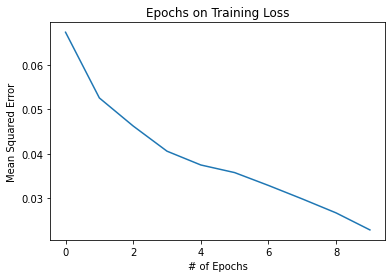

In [55]:
plt.plot(gaussian_history.epoch, gaussian_history.history['loss'])
plt.title('Epochs on Training Loss')
plt.xlabel('# of Epochs')
plt.ylabel('Mean Squared Error')
plt.show()

In [56]:
# gaussian_auto_encoder.save('gaussian_blur.model')
# files.download('gaussian_blur.model')

### build the model

In [57]:
# Evaluate the model on the test set

result = gaussian_auto_encoder.predict(xtest_noisy)
gaussian_auto_encoder.evaluate(xtest, xtest_noisy)

1/1 [==============================] - 1s 1s/step - loss: 0.0557


0.05571481212973595

(12, 300, 300, 3)


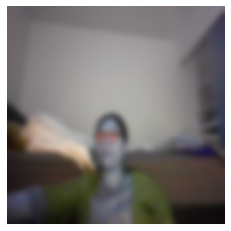

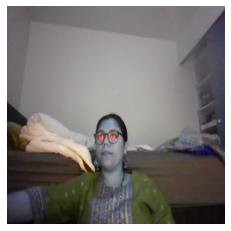

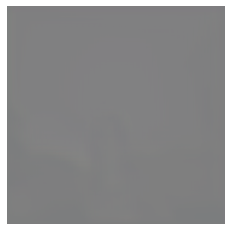

In [58]:
print(result.shape)
plot_rgb_img(xtest_noisy[0])
plot_rgb_img(xtest[0])
plot_rgb_img(result[0])

Ground Truth


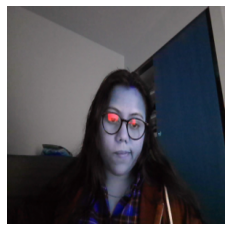

Noisy Image


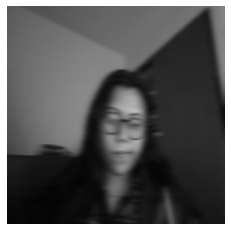

Denoised photo


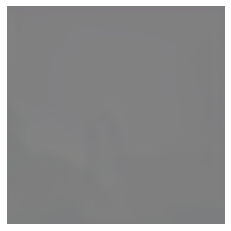

In [59]:
# Compare the images
print("Ground Truth")
plot_rgb_img(data[3])

print("Noisy Image")
plot_rgb_img(add_gaussian_blur_to_dataset(data[3]))

print("Denoised photo")
plot_rgb_img(result[1])


### Model sumary

In [60]:
gaussian_auto_encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 300, 300, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 150, 150, 64)     0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 150, 150, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           (None, 150, 150, 32)      18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 32)       0   

In [62]:
# plt.plot(history.epoch, history.history['loss'])
# plt.title('Epochs on Training Loss')
# plt.xlabel('# of Epochs')
# plt.ylabel('Mean Squared Error')
# plt.show()

## Run and Runtime 

In [63]:
import time
start = time.time()
encoded_imgs=autoencoder.encoder(xtest).numpy()
decoded_imgs=autoencoder.decoder(encoded_imgs)
end = time.time()
print("Elapsed time:"+ str(end-start))

NameError: ignored

In [ ]:
n = 4 
plt.figure(figsize=(20, 7))
plt.gray()
for i in range(n): 
  # display original + noise 
  bx = plt.subplot(3, n, i + 1) 
  plt.title("original + noise") 
  plt.imshow(tf.squeeze(xtest_noisy[i])) 
  plt.axis('off')
  
  # display reconstruction 
  cx = plt.subplot(3, n, i + n + 1) 
  plt.title("reconstructed") 
  plt.imshow(tf.squeeze(decoded_imgs[i])) 
  plt.axis('off')

  # display original 
  ax = plt.subplot(3, n, i + 2*n + 1) 
  plt.title("original") 
  plt.imshow(tf.squeeze(xtest[i])) 
  plt.axis('off')
  
plt.show()

## DeNoise Analyzer 

In [64]:
import skimage.metrics as measure
i=0
psnr1 = measure.peak_signal_noise_ratio(xtest[i],xtest_noisy[i])
psnr2 = measure.peak_signal_noise_ratio(xtest_noisy[i],decoded_imgs[i])
print("PSNR GroundTruth vs noisy " + str(psnr1))
print("PSNR noisy vs denoised " +str(psnr2))
print("PSNR Improvement" + str(psnr2-psnr1))

ssim1 = measure.structural_similarity(xtest[i],xtest_noisy[i],multichannel=True)
ssim2 = measure.structural_similarity(xtest[i],decoded_imgs[i],multichannel=True)
print("SSIM GroundTruth vs noisy " + str(ssim1))
print("SSIM noisy vs denoised " +str(ssim2))
print("SSIM Improvement" + str(ssim2-ssim1))

NameError: ignored

Ref:
https://keras.io/examples/vision/autoencoder/